In [285]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision

from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

### Toy MTL

"Is it a hotdog? Or is it not a hotdog"

Training sets will be identical for each task but labels will be binary classes for whether an example is or is not a particular digit. e.g., task 1 is about identifying digits are a 0 or not. task 2 is about identifying digits are a 1 or not.

In [286]:
mnist_train = torchvision.datasets.MNIST('/tmp/mnist', download=True, train=True)
mnist_test = torchvision.datasets.MNIST('/tmp/mnist', download=True, train=False)

In [290]:
x_train = mnist_train.data
y_train = mnist_train.targets

x_test = mnist_test.data
y_test = mnist_test.targets

In [291]:
t0_digit = 2
t1_digit = 5

# NOTE: x_train, x_test remains the same for both tasks

y_t0_train = torch.where(y_train == t0_digit, 1, 0)
y_t0_test = torch.where(y_test == t0_digit, 1, 0)
y_t1_train = torch.where(y_train == t1_digit, 1, 0)
y_t1_test = torch.where(y_test == t1_digit, 1, 0)

In [301]:
def accuracy(y_hat, y):
    assert y_hat.shape == y.shape
    n_classes = y_hat.shape[-1]
    y_hat = y_hat.view(-1, n_classes)
    y = y.view(-1, n_classes)
    n_correct = torch.sum(y_hat == y)
    return n_correct / y_hat.numel()

In [292]:
class MultiTaskDataset:
    def __init__(self, x, t0_y, t1_y):
        self.x = x
        self.t0_y = t0_y
        self.t1_y = t1_y
        
    def __getitem__(self, idx):
        return self.x[idx] / 255., self.t0_y[idx], self.t1_y[idx]
            
    def __len__(self):
        return len(self.x)

In [369]:
class TaskFiLM(nn.Module):
    def __init__(self, channels, n_tasks, embedding_dim=512):
        super().__init__()
        self.embed = nn.Embedding(n_tasks, embedding_dim)
        self.scale = nn.Linear(embedding_dim, channels)
        self.shift = nn.Linear(embedding_dim, channels)
        # TODO: initialize this layer so that scale is 1 and shift is 0
        
    def forward(self, task_idx):
        embedding = self.embed(task_idx)
        return self.scale(embedding), self.shift(embedding)
        

class FeaturewiseTransform(nn.Module):
    def forward(self, x, scale, shift):
        return scale * x + shift
                 
        
class MTL(nn.Module):
    """Generic multi-task learner."""

    def __init__(self, shared=True):
        super().__init__()
        
        self.shared = shared
        
        self.backbone = nn.Sequential(
            nn.Linear(28 * 28, 32),
            nn.ReLU(),
        )
        
        if not self.shared:
            self.backbone2 = nn.Sequential(
                nn.Linear(28 * 28, 32),
                nn.ReLU(),
            )
                
        self.t0_head = nn.Linear(32, 1)
        self.t1_head = nn.Linear(32, 1)
    
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        t0_logits = self.t0_head(self.backbone(x))
        
        if not self.shared:
            t1_logits = self.t1_head(self.backbone2(x))
        else:
            t1_logits = self.t1_head(self.backbone(x))
        
        return t0_logits, t1_logits
    
    def loss(self, x, t0_y, t1_y, t0_lambda=1.0, t1_lambda=1.0):
        t0_logits, t1_logits = self.forward(x)
        t0_logits = t0_logits.view(-1,)
        t1_logits = t1_logits.view(-1,)
        
        t0_loss = nn.functional.binary_cross_entropy_with_logits(t0_logits, t0_y)
        t1_loss = nn.functional.binary_cross_entropy_with_logits(t1_logits, t1_y)
        total_loss = t0_lambda * t0_loss + t1_lambda * t1_loss
        losses = {
            'loss/total': total_loss,
            'loss/t0': t0_loss,
            'loss/t1': t1_loss,
        }
        return losses
    
    
class FiLMTL(MTL):
    """Task-conditioned multi-task learner with FiLM."""
    
    def __init__(self, n_tasks):
        super().__init__()
   
        self.film_gen = TaskFiLM(32, n_tasks=n_tasks, embedding_dim=64)
        
        # backbone
        self.in_proj = nn.Linear(28 * 28, 32)
        self.transform = FeaturewiseTransform()
        self.relu = nn.ReLU()
        
        # heads
        self.t0_head = nn.Linear(32, 1)
        self.t1_head = nn.Linear(32, 1)
    
    def forward(self, x):
        x = x.view(-1, 28 * 28)

        t0_scale, t0_shift = self.film_gen(torch.zeros(x.shape[0], dtype=torch.long, device=x.device))
        t1_scale, t1_shift = self.film_gen(torch.ones(x.shape[0], dtype=torch.long, device=x.device))
        
        x = self.in_proj(x)
        
        t0_x = self.transform(x, t0_scale, t0_shift)
        t0_x = self.relu(t0_x)
        
        t1_x = self.transform(x, t1_scale, t1_shift)
        t1_x = self.relu(t1_x)
        
        t0_logits = self.t0_head(t0_x)
        t1_logits = self.t1_head(t1_x)
        return t0_logits, t1_logits

In [363]:
def train_mtl(
    *, 
    model, 
    train_loader, 
    val_loader, 
    lr=1e-3, 
    epochs=5, 
):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    train_metrics = {'loss/total': [], 
                     'loss/t0': [], 
                     'loss/t1': [],
                     'acc/t0': [],
                     'acc/t1': [],
                    }
    val_metrics = {'loss/total': [], 
                     'loss/t0': [], 
                     'loss/t1': [],
                     'acc/t0': [],
                     'acc/t1': [],
                    }

    for epoch in range(epochs):
        model.train()
        for batch in tqdm(train_loader, total=len(train_loader)):    
            im, t0_labels, t1_labels = batch
            
            loss = model.loss(im, t0_labels.float(), t1_labels.float())
            total_loss = loss['loss/total']

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            # loss metrics
            for k in train_metrics.keys():
                if k in loss:
                    train_metrics[k].append(loss[k].item())

            # accuracy metrics
            t0_logits, t1_logits = model.forward(im)
            t0_pred = nn.functional.sigmoid(t0_logits) > 0.5
            t1_pred = nn.functional.sigmoid(t1_logits) > 0.5
            train_metrics['acc/t0'].append(accuracy(t0_pred[:, 0], t0_labels.bool()))
            train_metrics['acc/t1'].append(accuracy(t1_pred[:, 0], t1_labels.bool()))


        t0_val_loss = 0
        t1_val_loss = 0
        t0_val_acc = 0
        t1_val_acc = 0
        val_count = 0

        model.eval()
        for batch in val_loader:
            im, t0_labels, t1_labels = batch
            val_loss = model.loss(im, t0_labels.float(), t1_labels.float())

            val_count += len(im)        
            t0_val_loss += val_loss['loss/t0'].item() * len(im)
            t1_val_loss += val_loss['loss/t1'].item() * len(im)

            # accuracy metrics
            t0_logits, t1_logits = model.forward(im)
            t0_pred = torch.sigmoid(t0_logits) > 0.5
            t1_pred = torch.sigmoid(t1_logits) > 0.5
            t0_val_acc += accuracy(t0_pred[:, 0], t0_labels.bool()).item() * len(im)
            t1_val_acc += accuracy(t1_pred[:, 0], t1_labels.bool()).item() * len(im)

        val_metrics['loss/t0'].append(t0_val_loss / val_count)
        val_metrics['loss/t1'].append(t1_val_loss / val_count)
        val_metrics['acc/t0'].append(t0_val_acc / val_count)
        val_metrics['acc/t1'].append(t1_val_acc / val_count)
    
    return train_metrics, val_metrics

In [352]:
EPOCHS = 5
LR = 3e-4
BATCH_SIZE = 512

train_ds = MultiTaskDataset(x_train, y_t0_train, y_t1_train)
val_ds = MultiTaskDataset(x_test, y_t0_test, y_t1_test)
train_iter = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_iter = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=False)

In [353]:
mtl = MTL(shared=True)
_, shared_metrics = train_mtl(
    model=mtl,
    train_loader=train_iter, 
    val_loader=val_iter,
    lr=LR, 
    epochs=EPOCHS,
)

100%|██████████████████████████| 118/118 [00:00<00:00, 174.00it/s]


In [371]:
mtl = MTL(shared=False)
_, separate_metrics = train_mtl(
    model=mtl,
    train_loader=train_iter, 
    val_loader=val_iter,
    lr=LR, 
    epochs=EPOCHS,
)

100%|██████████████████████████| 118/118 [00:00<00:00, 165.32it/s]


In [372]:
mtl = FiLMTL(n_tasks=2)
_, film_metrics = train_mtl(
    model=mtl,
    train_loader=train_iter, 
    val_loader=val_iter,
    lr=LR, 
    epochs=EPOCHS,
)

100%|██████████████████████████| 118/118 [00:00<00:00, 163.23it/s]


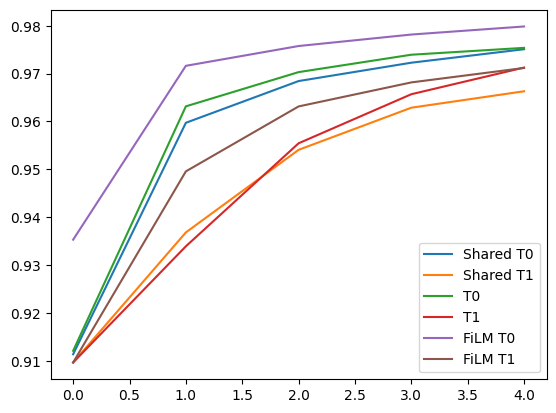

In [373]:
fig, ax = plt.subplots()
ax.plot(shared_metrics['acc/t0'], label='Shared T0')
ax.plot(shared_metrics['acc/t1'], label='Shared T1')
ax.plot(separate_metrics['acc/t0'], label='T0')
ax.plot(separate_metrics['acc/t1'], label='T1')
ax.plot(film_metrics['acc/t0'], label='FiLM T0')
ax.plot(film_metrics['acc/t1'], label='FiLM T1')
ax.legend()